# Supervised machine learning classification (without deep learning)

Supervised clsssification of structures localized by cryo-electron tomography by Logistic regression and SVM. In both cases the following steps are performed:
* Cross-validation for multiple random testing, training data separation, each for different feature set and scaling
* Validation graphs to access overfitting
* Prediction

The structures classified here are protein bridges that link plasma membrane and synaptic vesicles (tethers), bioRxiv https://doi.org/10.1101/2024.12.18.629213

Prerequisites (input data):
* Table of features for all structures
* Annotated subset of structures

Instructions:
* All cells from the Initialization section have to be executed first, in order
* Cells from Logistiregression and Support vector machine sections can be executed in any order

Uses scikit-learn.

## Initialization

In [2]:
import os
import sys
from pathlib import Path
import subprocess
import importlib
import pickle
import logging

import numpy as np
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from IPython.core.display import HTML  # depreciated
except ImportError:
    from IPython.display import display, HTML

import sklearn as sk
from sklearn import preprocessing as sk_preproc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
import sklearn.discriminant_analysis
import sklearn.pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import graphviz

import pyto
from pyto.io.pandas_io import PandasIO  
from pyto.ai.ml_supervised import MLSupervised 
import pyto.ai.feature_transform_tethers  
from pyto.ai.feature_transform_tethers import combine_features
from pyto.ai.feature_transform_tethers import transform_df, get_transformer_robust
from pyto.ai.feature_transform_tethers import get_transformer_logstd, get_transformer_logrobust

%autosave 0
sys.version, sklearn.__version__

Info: Neural net functionality cannot be used because module torch was not found.


Autosave disabled


('3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]',
 '1.2.2')

In [2]:
# Settings

# force showing all rows in a table (default 60 rows)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# seaborn plots
#sns.set_theme()
#sns.set_context('talk')
#sns.reset_orig()

# set hostname
hostname = os.uname()[1]
print("Host name: ", hostname)

Host name:  rauna


### Figures

In [3]:
# Useful functions for figures

# set plot parameters
def set_plot(plot_type):
    
    # for making figures 
    if plot_type == 'figure_save':
        # for some reason need to repeat
        %matplotlib qt
        plt.rcParams['font.size'] = 15
        %matplotlib qt
        plt.rcParams['font.size'] = 15
    
    # figure-like inline
    if plot_type == 'figure_inline':
        %matplotlib inline
        plt.rcParams['font.size'] = 16
    
    # standard inline
    if plot_type == 'inline':
        %matplotlib inline
        print(f"Figure size hanged from default {plt.rcParams['figure.figsize']}")
        plt.rcParams["figure.figsize"] = [4.5, 3]  # workaround changed size 2.2023

In [4]:
# choose figure type, uncomment one
#plot_type = 'figure_save' 
plot_type = 'figure_inline'
#plot_type = 'inline'

set_plot(plot_type)

In [5]:
# Standard inline
%matplotlib inline
print(f"Changed from default {plt.rcParams['figure.figsize']}")
plt.rcParams["figure.figsize"] = [4.5, 3]  # workaround changed size 2.2023

Changed from default [6.4, 4.8]


### General parameters and setup

In [16]:
# Parameters 

# Need to be consistent with output of munc13-snap25

# Directory where input data for ML is saved (absolute or 
# relative to this dir). These incude:
#   - munc13 snap25 presynaptic project data
#   - additional munc13 snap25 presynaptic analysis
#   - manual annotations
input_dir = 'input_data/tethers'

# Input tether indexed and scalar data (original data, additional 
# features and annotations), file names without extension
data_base = 'm13-snap25_data'
metadata_base = 'm13-snap25_metadata'

# Directory where predictions + annotations are saved
output_dir = 'output_data/ml_munc13'


# Initialization

# make paths from the above (absolute or relative to this directory)
data_path = os.path.join(input_dir, data_base)
metadata_path = os.path.join(input_dir, metadata_base)


### Get data

In [7]:
# useful groups of columns

# common columns
common_cols = ['group', 'identifiers', 'ids']

# basic features (used for the manuscript)
features_basic_2 = [
    'thresh', 'thresh_rank', 'density_mean', 'density_std',
    'length_nm', 'length_min_nm', 'length_median_nm', 'length_max_nm',
    'boundary_distance_nm', 'distance_nm', 
    'surface_nm', 'volume_nm', 'euler', 'n_loops']

# standard features (original and derived wo highly correlated) v2
features_std_v2 = [
    'length_nm', 'length_max_nm',
    'boundary_distance_nm', 'distance_nm', 'length_curve', 'length_max_min', 
    'length_curve_ratio', 'length_max_min_ratio', 
    'length_bound_ratio',
    'thresh_rank', 'volume_nm', 'v-s', 'svr',
    'len_v_ratio', 'n_loops', 'loops_v_ratio'] 

In [8]:
# Read data 
df_io = PandasIO(calling_dir=os.getcwd())
input_data = df_io.read_table(
    base=data_path, 
    out_desc='Full analysis with Munc13 and SNARE annotations')
metadata = df_io.read_table(
    base=metadata_path, 
    out_desc='Full analysis with Munc13 and SNARE annotations metadata')

# training data, add combinations of features
munc13_data = MLSupervised().get_labeled(df=input_data, column='munc13').copy()
munc13_data, comb_features = combine_features(munc13_data)

# prediction data
input_data_feat, comb_features = combine_features(input_data)
munc13_prediction_data = input_data_feat.loc[
    np.setdiff1d(input_data_feat.index, munc13_data.index), :]


Read Full analysis with Munc13 and SNARE annotations pickle input_data/tethers/m13-snap25_data.pkl
Read Full analysis with Munc13 and SNARE annotations metadata pickle input_data/tethers/m13-snap25_metadata.pkl


## Logistic regression

### Range of random states

#### Basic features

Best estimator: {'C': 10}
Training score for the best estimator:  0.756
Test score for the best estimator:  0.790
f1 macro scores for the best estimator: train  0.756, test  0.790


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,22,5,3,13,3,0
1,6,24,18,2,9,7
2,0,8,241,0,1,75


Best estimator: {'C': 100}
Training score for the best estimator:  0.821
Test score for the best estimator:  0.771
f1 macro scores for the best estimator: train  0.821, test  0.771


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,3,2,10,3,2
1,5,35,13,2,8,3
2,0,12,231,0,2,80


Best estimator: {'C': 10}
Training score for the best estimator:  0.769
Test score for the best estimator:  0.761
f1 macro scores for the best estimator: train  0.769, test  0.761


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,3,2,7,0,1
1,8,23,19,4,8,4
2,0,10,229,0,3,83


Best estimator: {'C': 100}
Training score for the best estimator:  0.763
Test score for the best estimator:  0.848
f1 macro scores for the best estimator: train  0.763, test  0.848


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,4,4,10,1,0
1,10,27,16,0,9,4
2,0,7,232,0,5,81


Best estimator: {'C': 1000}
Training score for the best estimator:  0.815
Test score for the best estimator:  0.783
f1 macro scores for the best estimator: train  0.815, test  0.783


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,2,3,8,1,0
1,6,27,13,3,11,6
2,0,9,235,0,4,77


Best estimator: {'C': 10}
Training score for the best estimator:  0.820
Test score for the best estimator:  0.724
f1 macro scores for the best estimator: train  0.820, test  0.724


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,2,3,7,1,0
1,5,31,16,4,6,4
2,0,10,227,0,4,84


Best estimator: {'C': 3}
Training score for the best estimator:  0.796
Test score for the best estimator:  0.746
f1 macro scores for the best estimator: train  0.796, test  0.746


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,1,3,8,1,1
1,7,23,17,2,8,9
2,0,7,237,0,3,78


Best estimator: {'C': 10}
Training score for the best estimator:  0.834
Test score for the best estimator:  0.665
f1 macro scores for the best estimator: train  0.834, test  0.665


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,2,7,5,2
1,4,32,15,4,7,4
2,0,9,235,0,2,79


Best estimator: {'C': 1}
Training score for the best estimator:  0.770
Test score for the best estimator:  0.752
f1 macro scores for the best estimator: train  0.770, test  0.752


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,16,9,3,12,5,1
1,2,31,16,1,9,7
2,0,5,245,0,2,73


Best estimator: {'C': 300}
Training score for the best estimator:  0.746
Test score for the best estimator:  0.717
f1 macro scores for the best estimator: train  0.746, test  0.717


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,3,3,8,0,0
1,8,16,17,4,9,12
2,2,5,241,1,3,73


Best estimator: {'C': 100}
Training score for the best estimator:  0.819
Test score for the best estimator:  0.778
f1 macro scores for the best estimator: train  0.819, test  0.778


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,2,10,2,2
1,4,32,17,2,9,2
2,0,12,230,0,5,78


Best estimator: {'C': 300}
Training score for the best estimator:  0.828
Test score for the best estimator:  0.658
f1 macro scores for the best estimator: train  0.828, test  0.658


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,4,8,4,0
1,7,33,10,3,6,7
2,1,6,236,0,7,75


Best estimator: {'C': 3}
Training score for the best estimator:  0.813
Test score for the best estimator:  0.630
f1 macro scores for the best estimator: train  0.813, test  0.630


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,2,9,1,1
1,6,29,15,7,4,5
2,0,8,234,0,6,77


Best estimator: {'C': 100}
Training score for the best estimator:  0.840
Test score for the best estimator:  0.696
f1 macro scores for the best estimator: train  0.840, test  0.696


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,11,3,1
1,4,34,13,6,6,3
2,0,8,237,0,3,77


Best estimator: {'C': 300}
Training score for the best estimator:  0.829
Test score for the best estimator:  0.590
f1 macro scores for the best estimator: train  0.829, test  0.590


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,2,7,2,2
1,5,33,13,6,3,6
2,0,10,231,1,2,81


Best estimator: {'C': 100}
Training score for the best estimator:  0.815
Test score for the best estimator:  0.668
f1 macro scores for the best estimator: train  0.815, test  0.668


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,11,3,1
1,5,27,13,6,7,8
2,1,7,243,0,4,70


Best estimator: {'C': 3}
Training score for the best estimator:  0.824
Test score for the best estimator:  0.768
f1 macro scores for the best estimator: train  0.824, test  0.768


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,3,2,9,0,1
1,7,32,11,3,8,5
2,0,9,232,0,5,79


Best estimator: {'C': 30}
Training score for the best estimator:  0.798
Test score for the best estimator:  0.625
f1 macro scores for the best estimator: train  0.798, test  0.625


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,3,2,5,2,2
1,6,27,16,7,6,4
2,0,11,230,0,2,82


Best estimator: {'C': 3}
Training score for the best estimator:  0.769
Test score for the best estimator:  0.769
f1 macro scores for the best estimator: train  0.769, test  0.769


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,2,2,10,0,2
1,8,21,19,3,8,7
2,0,8,237,0,2,78


Best estimator: {'C': 30}
Training score for the best estimator:  0.824
Test score for the best estimator:  0.641
f1 macro scores for the best estimator: train  0.824, test  0.641


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,1,7,6,2
1,6,30,11,3,8,8
2,1,8,240,0,3,73


Best estimator: {'C': 10}
Training score for the best estimator:  0.834
Test score for the best estimator:  0.637
f1 macro scores for the best estimator: train  0.834, test  0.637


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,1,8,5,2
1,4,32,15,5,6,4
2,0,11,234,0,4,76


Best estimator: {'C': 100}
Training score for the best estimator:  0.808
Test score for the best estimator:  0.662
f1 macro scores for the best estimator: train  0.808, test  0.662


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,5,2,9,2,1
1,6,29,10,4,6,11
2,0,9,239,1,2,74


,random,f1_train,f1_test,f1,f1_weighted_train,f1_weighted_test,f1_weighted,accuracy_train,accuracy_test,accuracy,f1_diff
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,28.500000,0.804131,0.712634,0.781064,0.888973,0.842324,0.877405,0.893522,0.850413,0.882671,0.091497
std,6.493587,0.028702,0.068647,0.018683,0.013357,0.037921,0.009292,0.011152,0.033399,0.006962,0.087121
min,18.000000,0.746421,0.589714,0.739397,0.863424,0.785008,0.853459,0.871560,0.800000,0.867277,-0.084730
25%,23.250000,0.776232,0.659096,0.768870,0.880754,0.809973,0.871656,0.884557,0.818182,0.878719,0.030372
50%,28.500000,0.815115,0.720169,0.777918,0.891636,0.845346,0.877004,0.894495,0.854545,0.882151,0.076371
75%,33.750000,0.824245,0.768458,0.798099,0.899709,0.871842,0.883933,0.902141,0.879545,0.887300,0.169613
max,39.000000,0.840019,0.847536,0.811119,0.906306,0.911882,0.892188,0.908257,0.909091,0.894737,0.239026


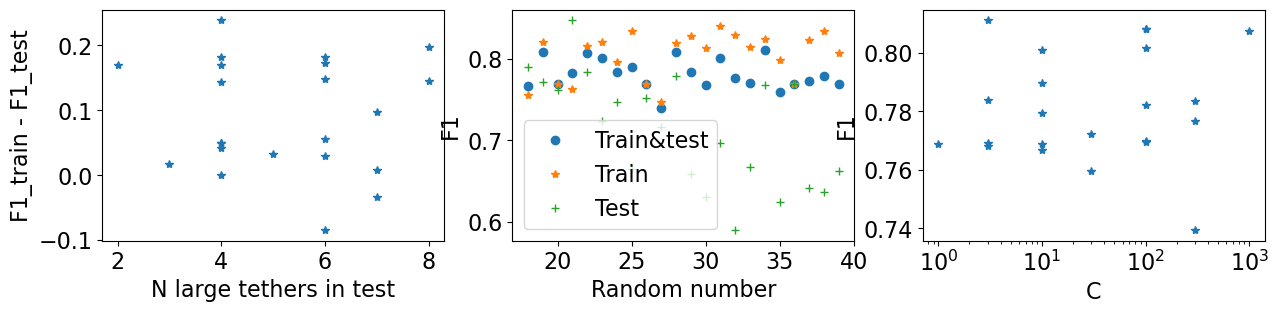

In [9]:
# Basic features k-fold, robust scaler

strat = None
f1_average='macro'
volume_thresh = 2000

features = features_basic_2
target = 'munc13_code'

train_big = []
test_big = []
random_s = []
f1_train = []
f1_test = []
f1 = []
f1_weighted_train = []
f1_weighted_test = []
f1_weighted = []
accuracy_train = []
accuracy_test = []
accuracy = []
param_c = []
for random_state in range(18, 40):

    # initialize data
    X = munc13_data[features]
    y = munc13_data[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, stratify=strat)
    train_big.append((X_train[["volume_nm"]] > volume_thresh).to_numpy().sum())
    test_big.append((X_test[["volume_nm"]] > volume_thresh).to_numpy().sum())

    param_grid = {
        'clf__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}
    tr, tr_col = get_transformer_robust(features=features)

    clf = sk.linear_model.LogisticRegression(
        solver='newton-cg', multi_class='multinomial', max_iter=int(1e5))
    pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
    param_search = GridSearchCV(pipe, param_grid, cv=None, scoring='f1_macro')
    ml = MLSupervised(
        estim=param_search, random_state=random_state, stratify=strat, cv=None, 
        print_coefs=False, single_print_report=False, cv_print_report=False)
    clf_best = ml.evaluate(data=munc13_data, features=features, target=target)

    pred_train = param_search.best_estimator_.predict(X_train)
    pred_test = param_search.best_estimator_.predict(X_test)
    prediction = param_search.best_estimator_.predict(X)
    f1_train.append(f1_score(y_train, pred_train, average=f1_average))
    f1_test.append(f1_score(y_test, pred_test, average=f1_average))
    f1_weighted_train.append(f1_score(y_train, pred_train, average='weighted'))
    f1_weighted_test.append(f1_score(y_test, pred_test, average='weighted'))
    f1_weighted.append(f1_score(y, prediction, average='weighted'))
    accuracy_train.append(accuracy_score(y_train, pred_train))
    accuracy_test.append(accuracy_score(y_test, pred_test))
    accuracy.append(accuracy_score(y, prediction))
    random_s.append(random_state)
    param_c.append(clf_best.get_params()['C'])
    f1.append(f1_score(y, prediction, average=f1_average))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(test_big, np.array(f1_train) - np.array(f1_test), '*')
axes[0].set_xlabel('N large tethers in test')
axes[0].set_ylabel('F1_train - F1_test')
axes[1].plot(random_s, f1, 'o', label='Train&test')
axes[1].plot(random_s, f1_train, '*', label='Train')
axes[1].plot(random_s, f1_test, '+', label='Test')
axes[1].set_ylabel('F1')
axes[1].set_xlabel('Random number')
axes[1].legend()#loc=(1.05, 0.7))
axes[2].plot(param_c, f1, '*')
axes[2].set_xscale("log")
axes[2].set_xlabel('C')
axes[2].set_ylabel('F1');

df = pd.DataFrame({
    'random': random_s, 
    'f1_train': f1_train, 'f1_test': f1_test, 'f1': f1,
    'f1_weighted_train': f1_weighted_train, 'f1_weighted_test': f1_weighted_test, 
    'f1_weighted': f1_weighted,
    'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'accuracy': accuracy})
df['f1_diff'] = df['f1_train'] - df['f1_test']
#df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')
df.describe()

Best estimator: {'C': 3}
Training score for the best estimator:  0.676
Test score for the best estimator:  0.742
f1 macro scores for the best estimator: train  0.676, test  0.742


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,17,9,4,13,3,0
1,10,21,17,2,7,9
2,0,8,241,1,1,74


Best estimator: {'C': 30}
Training score for the best estimator:  0.808
Test score for the best estimator:  0.722
f1 macro scores for the best estimator: train  0.808, test  0.722


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,3,2,10,3,2
1,5,33,15,3,6,4
2,0,13,230,0,2,80


Best estimator: {'C': 30}
Training score for the best estimator:  0.761
Test score for the best estimator:  0.718
f1 macro scores for the best estimator: train  0.761, test  0.718


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,2,3,5,2,1
1,11,23,16,3,9,4
2,1,9,229,0,4,82


Best estimator: {'C': 100}
Training score for the best estimator:  0.761
Test score for the best estimator:  0.794
f1 macro scores for the best estimator: train  0.761, test  0.794


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,4,4,8,3,0
1,10,28,15,1,8,4
2,1,8,230,0,2,84


Best estimator: {'C': 300}
Training score for the best estimator:  0.770
Test score for the best estimator:  0.773
f1 macro scores for the best estimator: train  0.770, test  0.773


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,3,3,8,1,0
1,10,23,13,4,11,5
2,1,8,235,0,4,77


Best estimator: {'C': 10}
Training score for the best estimator:  0.803
Test score for the best estimator:  0.618
f1 macro scores for the best estimator: train  0.803, test  0.618


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,4,3,5,3,0
1,5,30,17,5,5,4
2,0,9,228,0,6,82


Best estimator: {'C': 3}
Training score for the best estimator:  0.764
Test score for the best estimator:  0.702
f1 macro scores for the best estimator: train  0.764, test  0.702


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,4,3,8,1,1
1,9,22,16,4,7,8
2,0,6,238,1,2,78


Best estimator: {'C': 3}
Training score for the best estimator:  0.817
Test score for the best estimator:  0.698
f1 macro scores for the best estimator: train  0.817, test  0.698


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,2,7,5,2
1,5,29,17,3,8,4
2,0,8,236,0,1,80


Best estimator: {'C': 300}
Training score for the best estimator:  0.797
Test score for the best estimator:  0.762
f1 macro scores for the best estimator: train  0.797, test  0.762


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,21,5,2,13,4,1
1,5,30,14,2,10,5
2,0,7,243,1,3,71


Best estimator: {'C': 300}
Training score for the best estimator:  0.734
Test score for the best estimator:  0.662
f1 macro scores for the best estimator: train  0.734, test  0.662


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,5,3,8,0,0
1,10,17,14,5,7,13
2,2,5,241,2,3,72


Best estimator: {'C': 30}
Training score for the best estimator:  0.796
Test score for the best estimator:  0.704
f1 macro scores for the best estimator: train  0.796, test  0.704


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,4,2,9,3,2
1,4,29,20,4,7,2
2,0,9,233,0,5,78


Best estimator: {'C': 30}
Training score for the best estimator:  0.771
Test score for the best estimator:  0.646
f1 macro scores for the best estimator: train  0.771, test  0.646


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23,7,4,10,2,0
1,8,30,12,6,5,5
2,1,4,238,0,9,73


Best estimator: {'C': 300}
Training score for the best estimator:  0.829
Test score for the best estimator:  0.668
f1 macro scores for the best estimator: train  0.829, test  0.668


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,4,2,9,1,1
1,4,33,13,7,6,3
2,1,8,233,2,4,77


Best estimator: {'C': 30}
Training score for the best estimator:  0.816
Test score for the best estimator:  0.650
f1 macro scores for the best estimator: train  0.816, test  0.650


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,9,5,1
1,7,31,13,6,6,3
2,0,7,238,0,4,76


Best estimator: {'C': 1000}
Training score for the best estimator:  0.824
Test score for the best estimator:  0.634
f1 macro scores for the best estimator: train  0.824, test  0.634


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,5,2,7,2,2
1,5,34,12,6,5,4
2,0,8,233,1,3,80


Best estimator: {'C': 1000}
Training score for the best estimator:  0.828
Test score for the best estimator:  0.614
f1 macro scores for the best estimator: train  0.828, test  0.614


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,9,5,1
1,3,29,13,6,6,9
2,1,9,241,0,4,70


Best estimator: {'C': 3}
Training score for the best estimator:  0.791
Test score for the best estimator:  0.743
f1 macro scores for the best estimator: train  0.791, test  0.743


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,4,3,8,1,1
1,9,29,12,3,8,5
2,0,8,233,0,5,79


Best estimator: {'C': 30}
Training score for the best estimator:  0.816
Test score for the best estimator:  0.692
f1 macro scores for the best estimator: train  0.816, test  0.692


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,3,2,6,1,2
1,5,29,15,5,8,4
2,0,10,231,0,4,80


Best estimator: {'C': 3}
Training score for the best estimator:  0.802
Test score for the best estimator:  0.696
f1 macro scores for the best estimator: train  0.802, test  0.696


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,2,2,7,3,2
1,5,25,18,4,8,6
2,0,9,236,0,1,79


Best estimator: {'C': 300}
Training score for the best estimator:  0.831
Test score for the best estimator:  0.625
f1 macro scores for the best estimator: train  0.831, test  0.625


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,4,1,7,6,2
1,4,31,12,4,7,8
2,1,7,241,0,2,74


Best estimator: {'C': 3}
Training score for the best estimator:  0.833
Test score for the best estimator:  0.581
f1 macro scores for the best estimator: train  0.833, test  0.581


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,1,6,6,3
1,5,33,13,5,6,4
2,0,9,236,0,6,74


Best estimator: {'C': 3}
Training score for the best estimator:  0.827
Test score for the best estimator:  0.631
f1 macro scores for the best estimator: train  0.827, test  0.631


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,2,2,7,4,1
1,7,27,11,3,6,12
2,0,6,242,0,3,74


,random,f1_train,f1_test,f1,f1_weighted_train,f1_weighted_test,f1_weighted,accuracy_train,accuracy_test,accuracy,f1_diff
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,28.500000,0.793479,0.685234,0.765702,0.885915,0.831465,0.872276,0.890603,0.838430,0.877470,0.108244
std,6.493587,0.038286,0.057106,0.022969,0.016277,0.039576,0.011014,0.014527,0.035369,0.009119,0.084019
min,18.000000,0.676037,0.581476,0.700471,0.844665,0.757025,0.843816,0.853211,0.772727,0.853547,-0.065988
25%,23.250000,0.770164,0.636901,0.762776,0.876008,0.809521,0.867342,0.883792,0.806818,0.872426,0.051313
50%,28.500000,0.802757,0.693774,0.770999,0.885543,0.840085,0.875898,0.889908,0.850000,0.881007,0.112919
75%,33.750000,0.822404,0.721135,0.779562,0.899506,0.856740,0.879462,0.902141,0.861364,0.883295,0.180076
max,39.000000,0.832726,0.793634,0.787978,0.910519,0.907586,0.884577,0.914373,0.909091,0.887872,0.251250


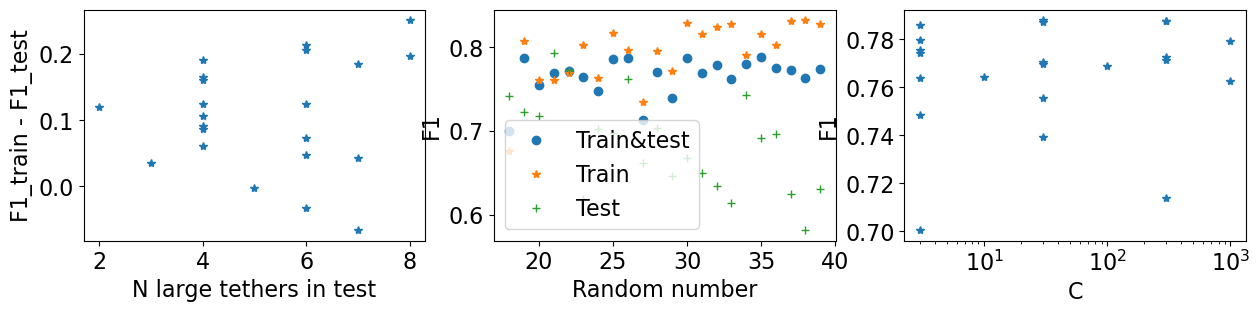

In [19]:
# Basic features k-fold, std scaler

strat = None
f1_average='macro'
volume_thresh = 2000

features = features_basic_2
target = 'munc13_code'

train_big = []
test_big = []
random_s = []
f1_train = []
f1_test = []
f1 = []
f1_weighted_train = []
f1_weighted_test = []
f1_weighted = []
accuracy_train = []
accuracy_test = []
accuracy = []
param_c = []
for random_state in range(18, 40):

    # initialize data
    X = munc13_data[features]
    y = munc13_data[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, stratify=strat)
    train_big.append((X_train[["volume_nm"]] > volume_thresh).to_numpy().sum())
    test_big.append((X_test[["volume_nm"]] > volume_thresh).to_numpy().sum())

    param_grid = {
        'clf__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}
    tr = sklearn.preprocessing.StandardScaler()

    clf = sk.linear_model.LogisticRegression(
        solver='newton-cg', multi_class='multinomial', max_iter=int(1e5))
    pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
    param_search = GridSearchCV(pipe, param_grid, cv=None, scoring='f1_macro')
    ml = MLSupervised(
        estim=param_search, random_state=random_state, stratify=strat, cv=None, 
        print_coefs=False, single_print_report=False, cv_print_report=False)
    clf_best = ml.evaluate(
        data=munc13_data, features=features, target=target)

    pred_train = param_search.best_estimator_.predict(X_train)
    pred_test = param_search.best_estimator_.predict(X_test)
    prediction = param_search.best_estimator_.predict(X)
    f1_train.append(f1_score(y_train, pred_train, average=f1_average))
    f1_test.append(f1_score(y_test, pred_test, average=f1_average))
    f1_weighted_train.append(f1_score(y_train, pred_train, average='weighted'))
    f1_weighted_test.append(f1_score(y_test, pred_test, average='weighted'))
    f1_weighted.append(f1_score(y, prediction, average='weighted'))
    accuracy_train.append(accuracy_score(y_train, pred_train))
    accuracy_test.append(accuracy_score(y_test, pred_test))
    accuracy.append(accuracy_score(y, prediction))
    random_s.append(random_state)
    param_c.append(clf_best.get_params()['C'])
    f1.append(f1_score(y, prediction, average=f1_average))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(test_big, np.array(f1_train) - np.array(f1_test), '*')
axes[0].set_xlabel('N large tethers in test')
axes[0].set_ylabel('F1_train - F1_test')
axes[1].plot(random_s, f1, 'o', label='Train&test')
axes[1].plot(random_s, f1_train, '*', label='Train')
axes[1].plot(random_s, f1_test, '+', label='Test')
axes[1].set_ylabel('F1')
axes[1].set_xlabel('Random number')
axes[1].legend()#loc=(1.05, 0.7))
axes[2].plot(param_c, f1, '*')
axes[2].set_xscale("log")
axes[2].set_xlabel('C')
axes[2].set_ylabel('F1');

df = pd.DataFrame({
    'random': random_s, 
    'f1_train': f1_train, 'f1_test': f1_test, 'f1': f1,
    'f1_weighted_train': f1_weighted_train, 'f1_weighted_test': f1_weighted_test, 
    'f1_weighted': f1_weighted,
    'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'accuracy': accuracy})
df['f1_diff'] = df['f1_train'] - df['f1_test']
#df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')
df.describe()

#### Standard features v2

Best estimator: {'C': 1000}
Training score for the best estimator:  0.785
Test score for the best estimator:  0.715
f1 macro scores for the best estimator: train  0.785, test  0.715


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,22,5,3,13,3,0
1,4,27,17,4,7,7
2,0,7,242,1,3,72


Best estimator: {'C': 300}
Training score for the best estimator:  0.855
Test score for the best estimator:  0.761
f1 macro scores for the best estimator: train  0.855, test  0.761


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,2,2,11,2,2
1,4,37,12,2,6,5
2,0,8,235,0,1,81


Best estimator: {'C': 3}
Training score for the best estimator:  0.793
Test score for the best estimator:  0.805
f1 macro scores for the best estimator: train  0.793, test  0.805


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,3,2,7,0,1
1,7,25,18,2,9,5
2,0,7,232,0,3,83


Best estimator: {'C': 1000}
Training score for the best estimator:  0.816
Test score for the best estimator:  0.743
f1 macro scores for the best estimator: train  0.816, test  0.743


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,4,4,8,3,0
1,5,34,14,1,8,4
2,0,7,232,0,8,78


Best estimator: {'C': 1000}
Training score for the best estimator:  0.827
Test score for the best estimator:  0.802
f1 macro scores for the best estimator: train  0.827, test  0.802


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,3,3,8,0,1
1,4,28,14,3,12,5
2,0,7,237,0,4,77


Best estimator: {'C': 100}
Training score for the best estimator:  0.822
Test score for the best estimator:  0.698
f1 macro scores for the best estimator: train  0.822, test  0.698


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,3,3,5,3,0
1,5,31,16,2,7,5
2,0,7,230,1,3,84


Best estimator: {'C': 3}
Training score for the best estimator:  0.816
Test score for the best estimator:  0.727
f1 macro scores for the best estimator: train  0.816, test  0.727


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,1,3,7,2,1
1,6,24,17,2,8,9
2,0,4,240,0,2,79


Best estimator: {'C': 1000}
Training score for the best estimator:  0.831
Test score for the best estimator:  0.716
f1 macro scores for the best estimator: train  0.831, test  0.716


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,2,10,2,2
1,3,31,17,4,7,4
2,0,7,237,1,3,77


Best estimator: {'C': 30}
Training score for the best estimator:  0.827
Test score for the best estimator:  0.773
f1 macro scores for the best estimator: train  0.827, test  0.773


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,22,3,3,16,1,1
1,3,31,15,3,7,7
2,0,6,244,0,2,73


Best estimator: {'C': 1000}
Training score for the best estimator:  0.801
Test score for the best estimator:  0.790
f1 macro scores for the best estimator: train  0.801, test  0.790


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,2,4,8,0,0
1,5,21,15,2,12,11
2,0,6,242,1,2,74


Best estimator: {'C': 10}
Training score for the best estimator:  0.835
Test score for the best estimator:  0.782
f1 macro scores for the best estimator: train  0.835, test  0.782


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,2,11,1,2
1,3,33,17,2,7,4
2,0,7,235,0,3,80


Best estimator: {'C': 3}
Training score for the best estimator:  0.836
Test score for the best estimator:  0.705
f1 macro scores for the best estimator: train  0.836, test  0.705


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,4,9,3,0
1,6,32,12,3,7,6
2,1,3,239,0,6,76


Best estimator: {'C': 10}
Training score for the best estimator:  0.819
Test score for the best estimator:  0.746
f1 macro scores for the best estimator: train  0.819, test  0.746


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,2,9,1,1
1,5,29,16,4,8,4
2,0,7,235,1,3,79


Best estimator: {'C': 10}
Training score for the best estimator:  0.837
Test score for the best estimator:  0.780
f1 macro scores for the best estimator: train  0.837, test  0.780


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,14,0,1
1,3,32,16,5,7,3
2,0,7,238,0,3,77


Best estimator: {'C': 30}
Training score for the best estimator:  0.855
Test score for the best estimator:  0.822
f1 macro scores for the best estimator: train  0.855, test  0.822


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,2,2,9,0,2
1,4,34,13,1,9,5
2,0,7,234,0,3,81


Best estimator: {'C': 300}
Training score for the best estimator:  0.823
Test score for the best estimator:  0.705
f1 macro scores for the best estimator: train  0.823, test  0.705


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,25,3,3,11,3,1
1,4,28,13,3,9,9
2,1,5,245,0,6,68


Best estimator: {'C': 3}
Training score for the best estimator:  0.829
Test score for the best estimator:  0.739
f1 macro scores for the best estimator: train  0.829, test  0.739


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,3,9,0,1
1,6,31,13,4,7,5
2,0,5,236,0,5,79


Best estimator: {'C': 1}
Training score for the best estimator:  0.800
Test score for the best estimator:  0.756
f1 macro scores for the best estimator: train  0.800, test  0.756


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,4,2,7,0,2
1,5,26,18,4,8,5
2,0,7,234,0,1,83


Best estimator: {'C': 300}
Training score for the best estimator:  0.823
Test score for the best estimator:  0.755
f1 macro scores for the best estimator: train  0.823, test  0.755


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,3,2,8,2,2
1,3,27,18,3,10,5
2,0,6,239,0,2,78


Best estimator: {'C': 30}
Training score for the best estimator:  0.853
Test score for the best estimator:  0.790
f1 macro scores for the best estimator: train  0.853, test  0.790


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,3,2,11,2,2
1,3,33,11,1,10,8
2,0,7,242,0,1,75


Best estimator: {'C': 3}
Training score for the best estimator:  0.870
Test score for the best estimator:  0.703
f1 macro scores for the best estimator: train  0.870, test  0.703


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,1,9,3,3
1,2,35,14,3,8,4
2,0,7,238,0,5,75


Best estimator: {'C': 100}
Training score for the best estimator:  0.852
Test score for the best estimator:  0.740
f1 macro scores for the best estimator: train  0.852, test  0.740


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,3,3,10,1,1
1,4,32,9,3,8,10
2,0,6,242,0,2,75


,random,f1_train,f1_test,f1,f1_weighted_train,f1_weighted_test,f1_weighted,accuracy_train,accuracy_test,accuracy,f1_diff
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,28.500000,0.827558,0.752457,0.808651,0.900882,0.859257,0.890369,0.905338,0.865702,0.895361,0.075101
std,6.493587,0.021524,0.037084,0.018882,0.011560,0.025823,0.009433,0.010142,0.025083,0.008480,0.042615
min,18.000000,0.784522,0.697557,0.765664,0.878970,0.793474,0.870179,0.886850,0.800000,0.876430,-0.011853
25%,23.250000,0.817066,0.718665,0.797969,0.894443,0.840543,0.883303,0.899847,0.854545,0.890160,0.053595
50%,28.500000,0.826588,0.750607,0.803316,0.899509,0.863917,0.889588,0.905199,0.872727,0.894737,0.071394
75%,33.750000,0.836554,0.781228,0.822532,0.909470,0.880211,0.896582,0.913609,0.888636,0.899314,0.107654
max,39.000000,0.870233,0.821890,0.847175,0.921848,0.895862,0.907640,0.923547,0.900000,0.910755,0.167326


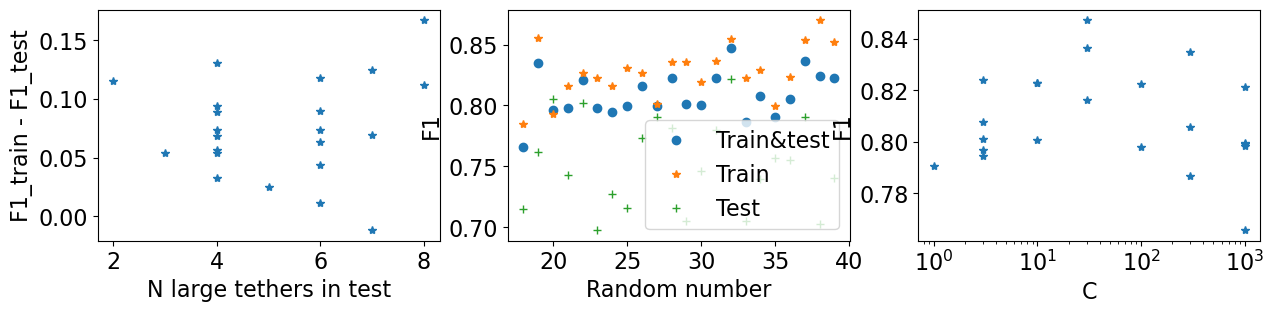

In [12]:
# Standard features v2 k-fold, logrobust scaler

strat = None
f1_average='macro'
volume_thresh = 2000

features = features_std_v2
target = 'munc13_code'

train_big = []
test_big = []
random_s = []
f1_train = []
f1_test = []
f1 = []
f1_weighted_train = []
f1_weighted_test = []
f1_weighted = []
accuracy_train = []
accuracy_test = []
accuracy = []
param_c = []
for random_state in range(18, 40):

    # initialize data
    X = munc13_data[features]
    y = munc13_data[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, stratify=strat)
    train_big.append((X_train[["volume_nm"]] > volume_thresh).to_numpy().sum())
    test_big.append((X_test[["volume_nm"]] > volume_thresh).to_numpy().sum())

    param_grid = {
        'clf__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}
    tr, tr_col = get_transformer_logrobust(features=features)

    clf = sk.linear_model.LogisticRegression(
        solver='newton-cg', multi_class='multinomial', max_iter=int(1e5))
    pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
    param_search = GridSearchCV(pipe, param_grid, cv=None, scoring='f1_macro')
    ml = MLSupervised(
        estim=param_search, random_state=random_state, stratify=strat, cv=None, 
        print_coefs=False, single_print_report=False, cv_print_report=False)
    clf_best = ml.evaluate(data=munc13_data, features=features, target=target)
    
    pred_train = param_search.best_estimator_.predict(X_train)
    pred_test = param_search.best_estimator_.predict(X_test)
    prediction = param_search.best_estimator_.predict(X)
    f1_train.append(f1_score(y_train, pred_train, average=f1_average))
    f1_test.append(f1_score(y_test, pred_test, average=f1_average))
    f1_weighted_train.append(f1_score(y_train, pred_train, average='weighted'))
    f1_weighted_test.append(f1_score(y_test, pred_test, average='weighted'))
    f1_weighted.append(f1_score(y, prediction, average='weighted'))
    accuracy_train.append(accuracy_score(y_train, pred_train))
    accuracy_test.append(accuracy_score(y_test, pred_test))
    accuracy.append(accuracy_score(y, prediction))
    random_s.append(random_state)
    param_c.append(clf_best.get_params()['C'])
    f1.append(f1_score(y, prediction, average=f1_average))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(test_big, np.array(f1_train) - np.array(f1_test), '*')
axes[0].set_xlabel('N large tethers in test')
axes[0].set_ylabel('F1_train - F1_test')
axes[1].plot(random_s, f1, 'o', label='Train&test')
axes[1].plot(random_s, f1_train, '*', label='Train')
axes[1].plot(random_s, f1_test, '+', label='Test')
axes[1].set_ylabel('F1')
axes[1].set_xlabel('Random number')
axes[1].legend()#loc=(1.05, 0.7))
axes[2].plot(param_c, f1, '*')
axes[2].set_xscale("log")
axes[2].set_xlabel('C')
axes[2].set_ylabel('F1');

df = pd.DataFrame({
    'random': random_s, 'C': param_c, 
    'f1_train': f1_train, 'f1_test': f1_test})
df['f1_diff'] = df['f1_train'] - df['f1_test']
df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')

df = pd.DataFrame({
    'random': random_s, 
    'f1_train': f1_train, 'f1_test': f1_test, 'f1': f1,
    'f1_weighted_train': f1_weighted_train, 'f1_weighted_test': f1_weighted_test, 
    'f1_weighted': f1_weighted,
    'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'accuracy': accuracy})
df['f1_diff'] = df['f1_train'] - df['f1_test']
#df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')
df.describe()

Best estimator: {'C': 300}
Training score for the best estimator:  0.785
Test score for the best estimator:  0.708
f1 macro scores for the best estimator: train  0.785, test  0.708


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,22,5,3,13,3,0
1,4,27,17,4,7,7
2,0,7,242,1,4,71


Best estimator: {'C': 300}
Training score for the best estimator:  0.847
Test score for the best estimator:  0.761
f1 macro scores for the best estimator: train  0.847, test  0.761


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,3,2,11,2,2
1,4,37,12,2,6,5
2,0,8,235,0,1,81


Best estimator: {'C': 3}
Training score for the best estimator:  0.799
Test score for the best estimator:  0.805
f1 macro scores for the best estimator: train  0.799, test  0.805


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,3,2,7,0,1
1,7,26,17,2,9,5
2,0,7,232,0,3,83


Best estimator: {'C': 1000}
Training score for the best estimator:  0.816
Test score for the best estimator:  0.743
f1 macro scores for the best estimator: train  0.816, test  0.743


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,4,4,8,3,0
1,5,34,14,1,8,4
2,0,7,232,0,8,78


Best estimator: {'C': 300}
Training score for the best estimator:  0.830
Test score for the best estimator:  0.802
f1 macro scores for the best estimator: train  0.830, test  0.802


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,3,3,8,0,1
1,4,28,14,3,12,5
2,0,6,238,0,4,77


Best estimator: {'C': 10}
Training score for the best estimator:  0.822
Test score for the best estimator:  0.722
f1 macro scores for the best estimator: train  0.822, test  0.722


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,3,3,5,3,0
1,5,31,16,2,7,5
2,0,7,230,0,2,86


Best estimator: {'C': 1}
Training score for the best estimator:  0.823
Test score for the best estimator:  0.727
f1 macro scores for the best estimator: train  0.823, test  0.727


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,1,3,7,2,1
1,6,25,16,2,8,9
2,0,4,240,0,2,79


Best estimator: {'C': 300}
Training score for the best estimator:  0.826
Test score for the best estimator:  0.716
f1 macro scores for the best estimator: train  0.826, test  0.716


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,2,10,2,2
1,3,31,17,4,7,4
2,1,7,236,1,3,77


Best estimator: {'C': 30}
Training score for the best estimator:  0.837
Test score for the best estimator:  0.773
f1 macro scores for the best estimator: train  0.837, test  0.773


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23,2,3,16,1,1
1,3,31,15,3,7,7
2,0,6,244,0,2,73


Best estimator: {'C': 1000}
Training score for the best estimator:  0.801
Test score for the best estimator:  0.790
f1 macro scores for the best estimator: train  0.801, test  0.790


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,3,4,8,0,0
1,5,22,14,2,12,11
2,0,6,242,1,2,74


Best estimator: {'C': 3}
Training score for the best estimator:  0.832
Test score for the best estimator:  0.738
f1 macro scores for the best estimator: train  0.832, test  0.738


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,2,10,2,2
1,3,33,17,3,6,4
2,0,8,234,0,2,81


Best estimator: {'C': 3}
Training score for the best estimator:  0.837
Test score for the best estimator:  0.759
f1 macro scores for the best estimator: train  0.837, test  0.759


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,4,12,0,0
1,6,32,12,3,7,6
2,0,4,239,0,7,75


Best estimator: {'C': 10}
Training score for the best estimator:  0.829
Test score for the best estimator:  0.746
f1 macro scores for the best estimator: train  0.829, test  0.746


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,2,9,1,1
1,4,30,16,4,8,4
2,0,7,235,1,3,79


Best estimator: {'C': 10}
Training score for the best estimator:  0.846
Test score for the best estimator:  0.761
f1 macro scores for the best estimator: train  0.846, test  0.761


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,13,1,1
1,2,33,16,5,7,3
2,0,7,238,0,3,77


Best estimator: {'C': 1}
Training score for the best estimator:  0.829
Test score for the best estimator:  0.805
f1 macro scores for the best estimator: train  0.829, test  0.805


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,2,8,1,2
1,4,30,17,1,9,5
2,0,6,235,0,2,82


Best estimator: {'C': 30}
Training score for the best estimator:  0.808
Test score for the best estimator:  0.727
f1 macro scores for the best estimator: train  0.808, test  0.727


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,25,3,3,11,3,1
1,5,26,14,2,10,9
2,0,6,245,0,6,68


Best estimator: {'C': 3}
Training score for the best estimator:  0.835
Test score for the best estimator:  0.739
f1 macro scores for the best estimator: train  0.835, test  0.739


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,3,3,9,0,1
1,6,32,12,4,7,5
2,0,5,236,0,5,79


Best estimator: {'C': 1}
Training score for the best estimator:  0.800
Test score for the best estimator:  0.747
f1 macro scores for the best estimator: train  0.800, test  0.747


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,4,2,7,0,2
1,5,26,18,4,8,5
2,0,7,234,0,2,82


Best estimator: {'C': 30}
Training score for the best estimator:  0.817
Test score for the best estimator:  0.755
f1 macro scores for the best estimator: train  0.817, test  0.755


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,3,2,8,2,2
1,3,26,19,3,10,5
2,0,6,239,0,2,78


Best estimator: {'C': 30}
Training score for the best estimator:  0.844
Test score for the best estimator:  0.790
f1 macro scores for the best estimator: train  0.844, test  0.790


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,25,4,2,11,2,2
1,3,33,11,1,10,8
2,0,7,242,0,1,75


Best estimator: {'C': 1}
Training score for the best estimator:  0.865
Test score for the best estimator:  0.737
f1 macro scores for the best estimator: train  0.865, test  0.737


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,1,9,3,3
1,2,34,15,3,9,3
2,0,7,238,0,3,77


Best estimator: {'C': 30}
Training score for the best estimator:  0.856
Test score for the best estimator:  0.718
f1 macro scores for the best estimator: train  0.856, test  0.718


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,3,3,9,2,1
1,4,32,9,3,8,10
2,0,5,243,0,2,75


,random,f1_train,f1_test,f1,f1_weighted_train,f1_weighted_test,f1_weighted,accuracy_train,accuracy_test,accuracy,f1_diff
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,28.500000,0.826476,0.753220,0.808063,0.900312,0.860219,0.890248,0.904782,0.866942,0.895257,0.073256
std,6.493587,0.019825,0.030006,0.016845,0.010876,0.023973,0.009079,0.009730,0.022886,0.008384,0.035734
min,18.000000,0.784522,0.708095,0.763520,0.882889,0.804511,0.868265,0.889908,0.809091,0.874142,-0.005738
25%,23.250000,0.816500,0.729883,0.798469,0.893083,0.850171,0.884483,0.899083,0.854545,0.890732,0.055866
50%,28.500000,0.828576,0.746351,0.808554,0.899010,0.863917,0.890193,0.903670,0.872727,0.894737,0.079871
75%,33.750000,0.836787,0.770163,0.823018,0.907441,0.876131,0.897208,0.911315,0.881818,0.901602,0.094978
max,39.000000,0.865115,0.804986,0.829927,0.924615,0.895010,0.903125,0.926606,0.900000,0.906178,0.137512


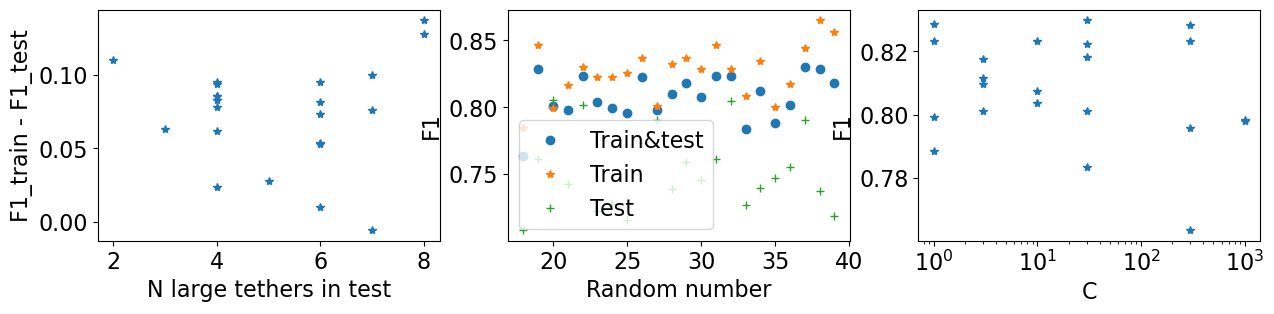

In [13]:
# Standard features v2 k-fold, logstd scaler

strat = None
f1_average='macro'
volume_thresh = 2000

features = features_std_v2
target = 'munc13_code'

train_big = []
test_big = []
random_s = []
f1_train = []
f1_test = []
f1 = []
f1_weighted_train = []
f1_weighted_test = []
f1_weighted = []
accuracy_train = []
accuracy_test = []
accuracy = []
param_c = []
for random_state in range(18, 40):

    # initialize data
    X = munc13_data[features]
    y = munc13_data[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, stratify=strat)
    train_big.append((X_train[["volume_nm"]] > volume_thresh).to_numpy().sum())
    test_big.append((X_test[["volume_nm"]] > volume_thresh).to_numpy().sum())

    param_grid = {
        'clf__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}
    tr, tr_col = get_transformer_logstd(features=features)

    clf = sk.linear_model.LogisticRegression(
        solver='newton-cg', multi_class='multinomial', max_iter=int(1e5))
    pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
    param_search = GridSearchCV(pipe, param_grid, cv=None, scoring='f1_macro')
    ml = MLSupervised(
        estim=param_search, random_state=random_state, stratify=strat, cv=None, 
        print_coefs=False, single_print_report=False, cv_print_report=False)
    clf_best = ml.evaluate(
        data=munc13_data, features=features, target=target)

    pred_train = param_search.best_estimator_.predict(X_train)
    pred_test = param_search.best_estimator_.predict(X_test)
    prediction = param_search.best_estimator_.predict(X)
    f1_train.append(f1_score(y_train, pred_train, average=f1_average))
    f1_test.append(f1_score(y_test, pred_test, average=f1_average))
    f1_weighted_train.append(f1_score(y_train, pred_train, average='weighted'))
    f1_weighted_test.append(f1_score(y_test, pred_test, average='weighted'))
    f1_weighted.append(f1_score(y, prediction, average='weighted'))
    accuracy_train.append(accuracy_score(y_train, pred_train))
    accuracy_test.append(accuracy_score(y_test, pred_test))
    accuracy.append(accuracy_score(y, prediction))
    random_s.append(random_state)
    param_c.append(clf_best.get_params()['C'])
    f1.append(f1_score(y, prediction, average=f1_average))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(test_big, np.array(f1_train) - np.array(f1_test), '*')
axes[0].set_xlabel('N large tethers in test')
axes[0].set_ylabel('F1_train - F1_test')
axes[1].plot(random_s, f1, 'o', label='Train&test')
axes[1].plot(random_s, f1_train, '*', label='Train')
axes[1].plot(random_s, f1_test, '+', label='Test')
axes[1].set_ylabel('F1')
axes[1].set_xlabel('Random number')
axes[1].legend()#loc=(1.05, 0.7))
axes[2].plot(param_c, f1, '*')
axes[2].set_xscale("log")
axes[2].set_xlabel('C')
axes[2].set_ylabel('F1');

df = pd.DataFrame({
    'random': random_s, 'C': param_c, 
    'f1_train': f1_train, 'f1_test': f1_test})
df['f1_diff'] = df['f1_train'] - df['f1_test']
df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')

df = pd.DataFrame({
    'random': random_s, 
    'f1_train': f1_train, 'f1_test': f1_test, 'f1': f1,
    'f1_weighted_train': f1_weighted_train, 'f1_weighted_test': f1_weighted_test, 
    'f1_weighted': f1_weighted,
    'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'accuracy': accuracy})
df['f1_diff'] = df['f1_train'] - df['f1_test']
#df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')
df.describe()

### Validation

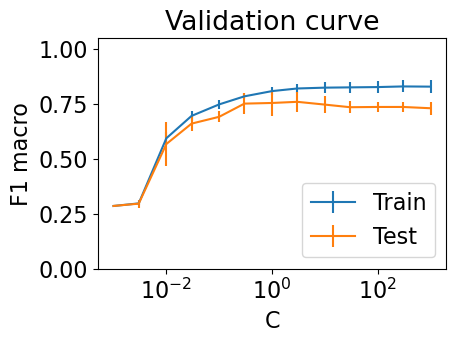

In [10]:
# Validation standard features v2

features = features_std_v2
target = 'munc13_code'
strat = None

transformer_func = get_transformer_logstd
param_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]

clf = sk.linear_model.LogisticRegression(
    solver='newton-cg', multi_class='multinomial', max_iter=int(1e5))
data_scaled = transform_df(data=munc13_data, transformer=transformer_func)

train_scores, test_scores = validation_curve(
    clf, data_scaled[features], munc13_data[target], scoring='f1_macro',
    param_name="C", param_range=param_range)
fig, ax = plt.subplots()
ax.errorbar(
    x=param_range, y=train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label='Train')
ax.errorbar(
    x=param_range, y=test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label='Test')
ax.set_xscale("log")
ax.set_xlabel('C')
ax.set_ylabel("F1 macro")
ax.set_title("Validation curve")
ax.set_ylim(0, 1.05)
ax.legend();

### Prediction

In [17]:

# general params
train_df = munc13_data.copy()
predict_df = munc13_prediction_data.copy()
target = 'munc13_code'
f1_average = 'macro'

# model params
features = features_std_v2
transformer_func = get_transformer_logstd
C = 1.

# base of the (output) predictions file
code = 'logreg_stdv2_logstd_c-1_test'


# train
clf = sk.linear_model.LogisticRegression(
    C=C, solver='newton-cg', multi_class='multinomial', max_iter=int(1e5))
tr, tr_col = transformer_func(features=features)
pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
X_train = train_df[features]
y_train = train_df[target]
ml = MLSupervised(
    scoring='f1_macro',  print_coefs=True, single_print_report=False)
clf_train = ml.fit_print_single(
    X_train=X_train, y_train=y_train, clf=pipe, 
    features=features, f1_average='macro', clf_step='clf');

# predict on anootated (training)
pred_train = clf_train.predict(X_train)
f1_train = f1_score(y_train, pred_train, average=f1_average)
print(f"F1 {f1_average} train score: {f1_train:6.3f}")
print(os.linesep + 'Train confusion matrix:')
ml.print_cm(
    y_train=y_train, pred_train=pred_train)
print(os.linesep + 'Train classification report:')
print(sk.metrics.classification_report(y_true=y_train, y_pred=pred_train))

# pedict non-annotated data
X_predict = predict_df[features]
predict = clf_train.predict(X_predict)

# save predictions and annotations
out_df = ml.save_predictions(
    train_df=train_df, predict_df=predict_df, y_predict_class=predict, 
    target=target, code=code, output_dir=output_dir)


Training score:  0.890
F1 macro train score:  0.797

Train confusion matrix:


,0,1,2
True,,,
0,39,3,4
1,8,34,24
2,0,9,316



Train classification report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        46
           1       0.74      0.52      0.61        66
           2       0.92      0.97      0.94       325

    accuracy                           0.89       437
   macro avg       0.83      0.78      0.80       437
weighted avg       0.88      0.89      0.88       437

Pickled json converted predictions and annotations to output_data/ml_munc13/logreg_stdv2_logstd_c-1_test_json.pkl


## Support vector machine

### Range of random states

#### Basic features

Best estimator: {'C': 10000.0, 'gamma': 0.001}
Training score for the best estimator:  0.809
Test score for the best estimator:  0.816
f1 macro scores for the best estimator: train  0.809, test  0.816


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,21,5,4,12,4,0
1,1,31,16,1,12,5
2,0,8,241,0,2,74


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.861
Test score for the best estimator:  0.738
f1 macro scores for the best estimator: train  0.861, test  0.738


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,2,2,10,3,2
1,2,37,14,2,6,5
2,0,9,234,0,1,81


Best estimator: {'C': 10000.0, 'gamma': 0.001}
Training score for the best estimator:  0.833
Test score for the best estimator:  0.749
f1 macro scores for the best estimator: train  0.833, test  0.749


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,2,3,5,2,1
1,3,31,16,2,10,4
2,0,10,229,1,2,83


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.805
Test score for the best estimator:  0.747
f1 macro scores for the best estimator: train  0.805, test  0.747


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,5,4,8,3,0
1,5,34,14,1,7,5
2,0,8,231,0,5,81


Best estimator: {'C': 100, 'gamma': 0.1}
Training score for the best estimator:  0.943
Test score for the best estimator:  0.704
f1 macro scores for the best estimator: train  0.943, test  0.704


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,34,1,2,7,2,0
1,0,42,4,4,10,6
2,0,5,239,0,8,73


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.818
Test score for the best estimator:  0.709
f1 macro scores for the best estimator: train  0.818, test  0.709


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,2,3,4,3,1
1,4,30,18,2,9,3
2,0,10,227,0,4,84


Best estimator: {'C': 1000, 'gamma': 0.01}
Training score for the best estimator:  0.840
Test score for the best estimator:  0.793
f1 macro scores for the best estimator: train  0.840, test  0.793


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,4,3,8,1,1
1,3,32,12,1,9,9
2,0,7,237,0,1,80


Best estimator: {'C': 1000, 'gamma': 0.01}
Training score for the best estimator:  0.883
Test score for the best estimator:  0.662
f1 macro scores for the best estimator: train  0.883, test  0.662


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,2,2,8,4,2
1,2,38,11,3,7,5
2,0,6,238,1,5,75


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.808
Test score for the best estimator:  0.808
f1 macro scores for the best estimator: train  0.808, test  0.808


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,20,5,3,16,1,1
1,2,31,16,2,9,6
2,0,7,243,0,3,72


Best estimator: {'C': 100, 'gamma': 0.001}
Training score for the best estimator:  0.724
Test score for the best estimator:  0.741
f1 macro scores for the best estimator: train  0.724, test  0.741


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,2,4,8,0,0
1,9,12,20,3,8,14
2,0,3,245,0,1,76


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.836
Test score for the best estimator:  0.778
f1 macro scores for the best estimator: train  0.836, test  0.778


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,2,10,2,2
1,3,35,15,2,9,2
2,0,10,232,0,5,78


Best estimator: {'C': 1000, 'gamma': 0.01}
Training score for the best estimator:  0.875
Test score for the best estimator:  0.787
f1 macro scores for the best estimator: train  0.875, test  0.787


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,25,5,4,11,1,0
1,0,42,8,1,9,6
2,0,6,237,0,8,74


Best estimator: {'C': 100, 'gamma': 0.01}
Training score for the best estimator:  0.861
Test score for the best estimator:  0.719
f1 macro scores for the best estimator: train  0.861, test  0.719


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,4,2,8,2,1
1,2,39,9,4,9,3
2,0,11,231,0,7,76


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.835
Test score for the best estimator:  0.753
f1 macro scores for the best estimator: train  0.835, test  0.753


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,14,0,1
1,4,33,14,5,7,3
2,0,8,237,0,6,74


Best estimator: {'C': 100, 'gamma': 0.01}
Training score for the best estimator:  0.814
Test score for the best estimator:  0.748
f1 macro scores for the best estimator: train  0.814, test  0.748


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,5,2,7,2,2
1,4,32,15,1,8,6
2,0,9,232,0,3,81


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.813
Test score for the best estimator:  0.767
f1 macro scores for the best estimator: train  0.813, test  0.767


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,12,2,1
1,6,27,12,3,11,7
2,0,8,243,0,4,70


Best estimator: {'C': 100, 'gamma': 0.1}
Training score for the best estimator:  0.947
Test score for the best estimator:  0.699
f1 macro scores for the best estimator: train  0.947, test  0.699


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,34,2,0,7,2,1
1,1,44,5,2,8,6
2,0,2,239,0,9,75


Best estimator: {'C': 10000.0, 'gamma': 0.001}
Training score for the best estimator:  0.833
Test score for the best estimator:  0.689
f1 macro scores for the best estimator: train  0.833, test  0.689


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,32,3,2,7,1,1
1,3,32,14,6,7,4
2,0,12,229,0,4,80


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.806
Test score for the best estimator:  0.753
f1 macro scores for the best estimator: train  0.806, test  0.753


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,2,2,7,3,2
1,4,25,19,2,11,5
2,0,9,236,0,2,78


Best estimator: {'C': 100, 'gamma': 0.01}
Training score for the best estimator:  0.830
Test score for the best estimator:  0.630
f1 macro scores for the best estimator: train  0.830, test  0.630


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,25,4,2,9,4,2
1,3,31,13,4,5,10
2,0,8,241,0,2,74


Best estimator: {'C': 10000.0, 'gamma': 0.001}
Training score for the best estimator:  0.890
Test score for the best estimator:  0.737
f1 macro scores for the best estimator: train  0.890, test  0.737


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,1,1,10,3,2
1,1,37,13,3,8,4
2,0,8,237,0,3,77


Best estimator: {'C': 10, 'gamma': 0.1}
Training score for the best estimator:  0.846
Test score for the best estimator:  0.737
f1 macro scores for the best estimator: train  0.846, test  0.737


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,6,2,9,2,1
1,2,35,8,2,9,10
2,0,9,239,0,3,74


,random,f1_train,f1_test,f1,f1_weighted_train,f1_weighted_test,f1_weighted,accuracy_train,accuracy_test,accuracy,f1_diff
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,28.500000,0.841326,0.739297,0.816470,0.907115,0.852480,0.893475,0.910064,0.857438,0.896817,0.102029
std,6.493587,0.048058,0.045394,0.033234,0.024857,0.030085,0.017189,0.022565,0.026820,0.014016,0.076028
min,18.000000,0.723898,0.629924,0.729902,0.864828,0.776439,0.849635,0.883792,0.800000,0.871854,-0.017059
25%,23.250000,0.813233,0.711292,0.799242,0.892750,0.827443,0.883599,0.896024,0.838636,0.886156,0.054057
50%,28.500000,0.833916,0.744122,0.815825,0.901896,0.860739,0.891787,0.905199,0.863636,0.894737,0.086678
75%,33.750000,0.860997,0.763353,0.827451,0.917307,0.874852,0.899805,0.916667,0.881818,0.903318,0.143498
max,39.000000,0.947091,0.816364,0.885912,0.969109,0.889174,0.931437,0.969419,0.890909,0.931350,0.247891


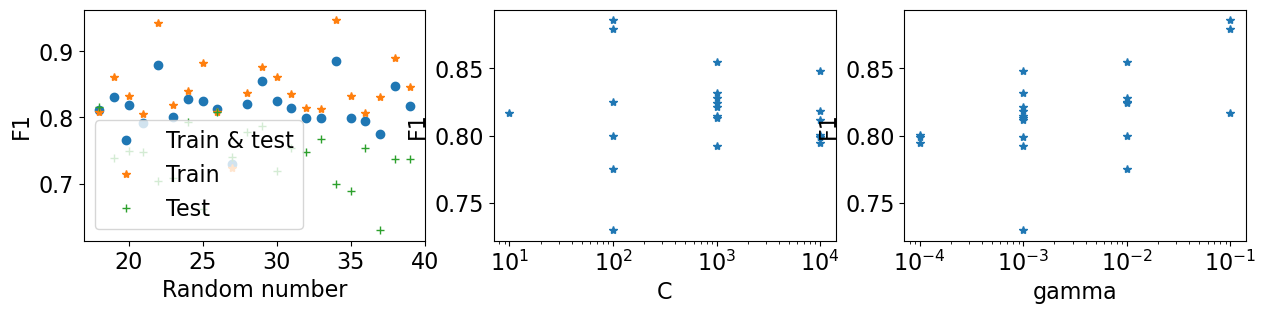

In [12]:
# Basic features K-fold, logrobust scaled

f1_average='macro'
volume_thresh = 2000
strat = None

features = features_basic_2
target = 'munc13_code'
transformer_func = get_transformer_logrobust

train_big = []
test_big = []
random_s = []
f1_train = []
f1_test = []
f1 = []
f1_weighted_train = []
f1_weighted_test = []
f1_weighted = []
accuracy_train = []
accuracy_test = []
accuracy = []
param_c = []
param_gamma = []
for random_state in range(18, 40):

    # initialize data
    X = munc13_data[features]
    y = munc13_data[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, stratify=strat)
    train_big.append((X_train[["volume_nm"]] > volume_thresh).to_numpy().sum())
    test_big.append((X_test[["volume_nm"]] > volume_thresh).to_numpy().sum())

    param_grid = {
        'clf__C': [0.1, 1, 10, 100, 1000, 1e4], 
        'clf__gamma': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
    tr, tr_col = transformer_func(features=features)

    clf = sk.svm.SVC(max_iter=int(1e6))
    pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
    param_search = GridSearchCV(pipe, param_grid, cv=None, scoring='f1_macro')
    ml = MLSupervised(
        estim=param_search, random_state=random_state, stratify=strat, 
        cv=None, print_coefs=False, single_print_report=False, cv_print_report=False)
    clf_best = ml.evaluate(
        data=munc13_data, features=features, target=target, )

    pred_train = param_search.best_estimator_.predict(X_train)
    pred_test = param_search.best_estimator_.predict(X_test)
    prediction = param_search.best_estimator_.predict(X)
    f1_train.append(f1_score(y_train, pred_train, average=f1_average))
    f1_test.append(f1_score(y_test, pred_test, average=f1_average))
    f1_weighted_train.append(f1_score(y_train, pred_train, average='weighted'))
    f1_weighted_test.append(f1_score(y_test, pred_test, average='weighted'))
    f1_weighted.append(f1_score(y, prediction, average='weighted'))
    accuracy_train.append(accuracy_score(y_train, pred_train))
    accuracy_test.append(accuracy_score(y_test, pred_test))
    accuracy.append(accuracy_score(y, prediction))
    random_s.append(random_state)
    param_c.append(clf_best.get_params()['C'])
    param_gamma.append(clf_best.get_params()['gamma'])
    prediction = param_search.best_estimator_.predict(X)
    f1.append(f1_score(y, prediction, average=f1_average))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
#axes[0].plot(test_big, np.array(f1_train) - np.array(f1_test), '*')
#axes[0].set_xlabel('N large tethers in test')
#axes[0].set_ylabel('F1_train - F1_test')
axes[0].plot(random_s, f1, 'o', label='Train & test')
axes[0].plot(random_s, f1_train, '*', label='Train')
axes[0].plot(random_s, f1_test, '+', label='Test')
axes[0].set_ylabel('F1')
axes[0].set_xlabel('Random number')
axes[0].legend()#loc=(1.05, 0.7))
axes[1].plot(param_c, f1, '*')
axes[1].set_xscale("log")
axes[1].set_xlabel('C')
axes[1].set_ylabel('F1');
axes[2].plot(param_gamma, f1, '*')
axes[2].set_xscale("log")
axes[2].set_xlabel('gamma')
axes[2].set_ylabel('F1');

df = pd.DataFrame({
    'random': random_s, 
    'f1_train': f1_train, 'f1_test': f1_test, 'f1': f1,
    'f1_weighted_train': f1_weighted_train, 'f1_weighted_test': f1_weighted_test, 
    'f1_weighted': f1_weighted,
    'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'accuracy': accuracy})
df['f1_diff'] = df['f1_train'] - df['f1_test']
#df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')
df.describe()

#### Standard features

Best estimator: {'C': 1000, 'gamma': 0.0001}
Training score for the best estimator:  0.740
Test score for the best estimator:  0.707
f1 macro scores for the best estimator: train  0.740, test  0.707


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,20,6,4,10,6,0
1,5,21,22,2,8,8
2,0,2,247,0,2,74


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.872
Test score for the best estimator:  0.784
f1 macro scores for the best estimator: train  0.872, test  0.784


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,28,1,2,11,2,2
1,4,38,11,2,7,4
2,0,7,236,0,1,81


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.837
Test score for the best estimator:  0.788
f1 macro scores for the best estimator: train  0.837, test  0.788


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,3,2,7,0,1
1,4,31,15,2,9,5
2,0,7,232,1,3,82


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.839
Test score for the best estimator:  0.758
f1 macro scores for the best estimator: train  0.839, test  0.758


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,1,4,8,3,0
1,5,33,15,1,8,4
2,0,6,233,0,6,80


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.836
Test score for the best estimator:  0.810
f1 macro scores for the best estimator: train  0.836, test  0.810


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,3,3,8,0,1
1,3,29,14,3,12,5
2,0,7,237,0,3,78


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.835
Test score for the best estimator:  0.760
f1 macro scores for the best estimator: train  0.835, test  0.760


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,2,3,6,1,1
1,5,32,15,3,7,4
2,0,7,230,0,1,87


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.817
Test score for the best estimator:  0.770
f1 macro scores for the best estimator: train  0.817, test  0.770


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,0,3,7,2,1
1,7,25,15,2,10,7
2,0,7,237,0,1,80


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.852
Test score for the best estimator:  0.565
f1 macro scores for the best estimator: train  0.852, test  0.565


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,1,2,7,5,2
1,4,32,15,7,4,4
2,0,6,238,2,3,76


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.830
Test score for the best estimator:  0.771
f1 macro scores for the best estimator: train  0.830, test  0.771


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23,2,3,16,1,1
1,5,32,12,5,7,5
2,0,7,243,0,1,74


Best estimator: {'C': 100, 'gamma': 0.001}
Training score for the best estimator:  0.723
Test score for the best estimator:  0.693
f1 macro scores for the best estimator: train  0.723, test  0.693


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,34,0,4,8,0,0
1,11,11,19,4,6,15
2,0,3,245,0,1,76


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.847
Test score for the best estimator:  0.711
f1 macro scores for the best estimator: train  0.847, test  0.711


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,2,8,4,2
1,2,35,16,2,7,4
2,0,8,234,0,3,80


Best estimator: {'C': 10, 'gamma': 0.01}
Training score for the best estimator:  0.803
Test score for the best estimator:  0.604
f1 macro scores for the best estimator: train  0.803, test  0.604


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,25,5,4,8,4,0
1,7,32,11,5,4,7
2,1,4,238,1,5,76


Best estimator: {'C': 100, 'gamma': 0.01}
Training score for the best estimator:  0.899
Test score for the best estimator:  0.734
f1 macro scores for the best estimator: train  0.899, test  0.734


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,31,2,2,7,3,1
1,1,40,9,4,9,3
2,0,7,235,0,2,81


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.837
Test score for the best estimator:  0.780
f1 macro scores for the best estimator: train  0.837, test  0.780


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,2,3,14,0,1
1,4,34,13,5,7,3
2,0,9,236,0,3,77


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.841
Test score for the best estimator:  0.800
f1 macro scores for the best estimator: train  0.841, test  0.800


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,4,2,7,2,2
1,4,35,12,1,11,3
2,0,8,233,0,3,81


Best estimator: {'C': 10, 'gamma': 0.1}
Training score for the best estimator:  0.931
Test score for the best estimator:  0.627
f1 macro scores for the best estimator: train  0.931, test  0.627


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,1,1,9,5,1
1,1,38,6,3,10,8
2,0,4,247,3,10,61


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.844
Test score for the best estimator:  0.708
f1 macro scores for the best estimator: train  0.844, test  0.708


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,29,5,2,8,1,1
1,6,37,7,4,7,5
2,0,7,234,0,6,78


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.824
Test score for the best estimator:  0.766
f1 macro scores for the best estimator: train  0.824, test  0.766


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,33,2,2,7,0,2
1,4,27,18,3,9,5
2,0,7,234,0,3,81


Best estimator: {'C': 10000.0, 'gamma': 0.001}
Training score for the best estimator:  0.849
Test score for the best estimator:  0.791
f1 macro scores for the best estimator: train  0.849, test  0.791


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,30,2,2,8,2,2
1,5,30,13,2,13,3
2,0,4,241,0,4,76


Best estimator: {'C': 10000.0, 'gamma': 0.0001}
Training score for the best estimator:  0.856
Test score for the best estimator:  0.713
f1 macro scores for the best estimator: train  0.856, test  0.713


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,26,3,2,9,4,2
1,2,32,13,1,8,10
2,0,6,243,0,1,75


Best estimator: {'C': 1000, 'gamma': 0.001}
Training score for the best estimator:  0.858
Test score for the best estimator:  0.678
f1 macro scores for the best estimator: train  0.858, test  0.678


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,3,1,9,3,3
1,2,33,16,4,7,4
2,0,5,240,0,5,75


Best estimator: {'C': 100, 'gamma': 0.001}
Training score for the best estimator:  0.785
Test score for the best estimator:  0.639
f1 macro scores for the best estimator: train  0.785, test  0.639


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,27,4,3,8,3,1
1,7,24,14,4,5,12
2,0,6,242,0,1,76


,random,f1_train,f1_test,f1,f1_weighted_train,f1_weighted_test,f1_weighted,accuracy_train,accuracy_test,accuracy,f1_diff
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,28.500000,0.834242,0.725397,0.806099,0.905713,0.847814,0.891161,0.910342,0.855372,0.896505,0.108845
std,6.493587,0.044674,0.068083,0.038231,0.019894,0.047829,0.018533,0.016492,0.045403,0.014140,0.079867
min,18.000000,0.722963,0.565159,0.714978,0.865555,0.734772,0.842910,0.880734,0.727273,0.869565,0.025410
25%,23.250000,0.825596,0.696739,0.807352,0.897894,0.821438,0.888726,0.902141,0.829545,0.894737,0.051447
50%,28.500000,0.838007,0.745860,0.816497,0.903924,0.870299,0.895982,0.906728,0.877273,0.899314,0.077533
75%,33.750000,0.851492,0.777831,0.829436,0.915465,0.883473,0.899879,0.917431,0.888636,0.903890,0.145752
max,39.000000,0.930891,0.810390,0.859012,0.959852,0.902141,0.921122,0.960245,0.909091,0.922197,0.303556


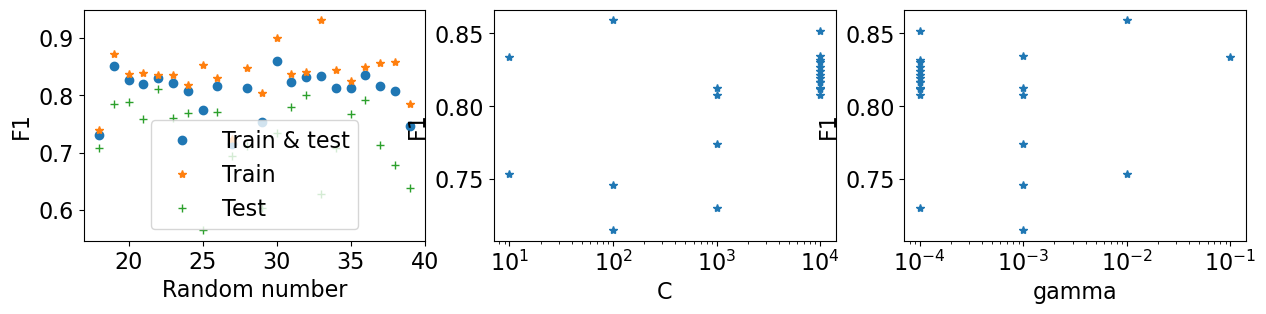

In [16]:
# Standard features K-fold, logrobust scaled

f1_average='macro'
volume_thresh = 2000
strat = None

features = features_std_v2
target = 'munc13_code'
transformer_func = get_transformer_logrobust

train_big = []
test_big = []
random_s = []
f1_train = []
f1_test = []
f1 = []
f1_weighted_train = []
f1_weighted_test = []
f1_weighted = []
accuracy_train = []
accuracy_test = []
accuracy = []
param_c = []
param_gamma = []
for random_state in range(18, 40):

    # initialize data
    X = munc13_data[features]
    y = munc13_data[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, stratify=strat)
    train_big.append((X_train[["volume_nm"]] > volume_thresh).to_numpy().sum())
    test_big.append((X_test[["volume_nm"]] > volume_thresh).to_numpy().sum())

    param_grid = {
        'clf__C': [0.1, 1, 10, 100, 1000, 1e4], 
        'clf__gamma': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
    tr, tr_col = transformer_func(features=features)

    clf = sk.svm.SVC(max_iter=int(1e6))
    pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
    param_search = GridSearchCV(pipe, param_grid, cv=None, scoring='f1_macro')
    ml = MLSupervised(
        estim=param_search, random_state=random_state, stratify=strat, 
        cv=None, print_coefs=False, single_print_report=False, cv_print_report=False)
    clf_best = ml.evaluate(
        data=munc13_data, features=features, target=target, )

    pred_train = param_search.best_estimator_.predict(X_train)
    pred_test = param_search.best_estimator_.predict(X_test)
    prediction = param_search.best_estimator_.predict(X)
    f1_train.append(f1_score(y_train, pred_train, average=f1_average))
    f1_test.append(f1_score(y_test, pred_test, average=f1_average))
    f1_weighted_train.append(f1_score(y_train, pred_train, average='weighted'))
    f1_weighted_test.append(f1_score(y_test, pred_test, average='weighted'))
    f1_weighted.append(f1_score(y, prediction, average='weighted'))
    accuracy_train.append(accuracy_score(y_train, pred_train))
    accuracy_test.append(accuracy_score(y_test, pred_test))
    accuracy.append(accuracy_score(y, prediction))
    random_s.append(random_state)
    param_c.append(clf_best.get_params()['C'])
    param_gamma.append(clf_best.get_params()['gamma'])
    prediction = param_search.best_estimator_.predict(X)
    f1.append(f1_score(y, prediction, average=f1_average))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
#axes[0].plot(test_big, np.array(f1_train) - np.array(f1_test), '*')
#axes[0].set_xlabel('N large tethers in test')
#axes[0].set_ylabel('F1_train - F1_test')
axes[0].plot(random_s, f1, 'o', label='Train & test')
axes[0].plot(random_s, f1_train, '*', label='Train')
axes[0].plot(random_s, f1_test, '+', label='Test')
axes[0].set_ylabel('F1')
axes[0].set_xlabel('Random number')
axes[0].legend()#loc=(1.05, 0.7))
axes[1].plot(param_c, f1, '*')
axes[1].set_xscale("log")
axes[1].set_xlabel('C')
axes[1].set_ylabel('F1');
axes[2].plot(param_gamma, f1, '*')
axes[2].set_xscale("log")
axes[2].set_xlabel('gamma')
axes[2].set_ylabel('F1');

df = pd.DataFrame({
    'random': random_s, 
    'f1_train': f1_train, 'f1_test': f1_test, 'f1': f1,
    'f1_weighted_train': f1_weighted_train, 'f1_weighted_test': f1_weighted_test, 
    'f1_weighted': f1_weighted,
    'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'accuracy': accuracy})
df['f1_diff'] = df['f1_train'] - df['f1_test']
#df.query("0 < f1_diff <= 0.1").sort_values('f1_diff')
df.describe()

### Validation

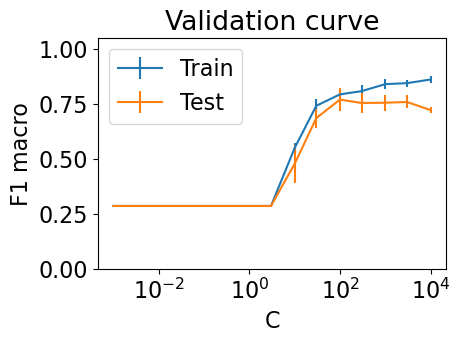

In [13]:
# Validation std gamma=0.001

features = features_std_v2
target = 'munc13_code'
strat = None

transformer_func = get_transformer_logrobust
param_range_C = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000]

clf = sk.svm.SVC(gamma=0.001, max_iter=int(1e6))
data_scaled = transform_df(data=munc13_data, transformer=transformer_func)

train_scores, test_scores = validation_curve(
    clf, data_scaled[features], munc13_data[target], scoring='f1_macro',
    param_name="C", param_range=param_range_C)
fig, ax = plt.subplots()
ax.errorbar(
    x=param_range_C, y=train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label='Train')
ax.errorbar(
    x=param_range_C, y=test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label='Test')
ax.set_xscale("log")
ax.set_xlabel('C')
ax.set_ylabel("F1 macro")
ax.set_title("Validation curve")
ax.set_ylim(0, 1.05)
ax.legend();

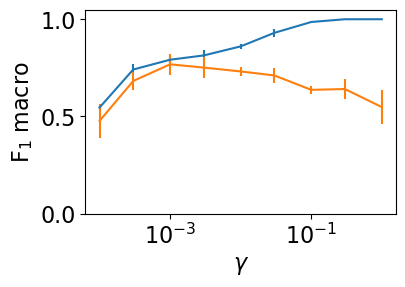

In [14]:
# Validation std v2 C=100

features = features_std_v2
target = 'munc13_code'
strat = None

transformer_func = get_transformer_logrobust
param_range_C = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
param_range_gamma = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]

clf = sk.svm.SVC(C=100, max_iter=int(1e6))
data_scaled = transform_df(data=munc13_data, transformer=transformer_func)

train_scores, test_scores = validation_curve(
    clf, data_scaled[features], munc13_data[target], scoring='f1_macro',
    param_name="gamma", param_range=param_range_gamma)
fig, ax = plt.subplots(figsize=(4.5, 3))
ax.errorbar(
    x=param_range_gamma, y=train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label='Train')
ax.errorbar(
    x=param_range_gamma, y=test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label='Test')
ax.set_xscale("log")
ax.set_xlabel('$\gamma$')
ax.set_ylabel("F$_1$ macro")
ax.set_title("Validation curve")
ax.legend();

if (plot_type == 'figure_save') or (plot_type == 'figure_inline'):
    ax.set_title('')
    ax.set_ylim((0, 1.05))
    ax.get_legend().remove()
    plt.subplots_adjust(bottom=0.2, left=0.21)
    #fig.savefig(os.path.join(
    #    Path.home(),
    #    'text/manuscripts/tether_ave_2024/figures/classification/'
    #    + 'svm_validation-C-100.pdf'))

### Prediction

In [18]:

# general params
train_df = munc13_data.copy()
predict_df = munc13_prediction_data.copy()
target = 'munc13_code'
f1_average = 'macro'

# model params
features = features_std_v2
transformer_func = get_transformer_logstd
C = 100.
gamma = 0.001

# base of the (output) predictions file
code = 'svm_stdv2_logstd_c-100_gamma-0.001_test'


# train
clf = sk.svm.SVC(C=100., gamma=0.001, max_iter=int(1e6))
tr, tr_col = transformer_func(features=features)
pipe = sk.pipeline.Pipeline([("scaler", tr), ("clf", clf)])
X_train = train_df[features]
y_train = train_df[target]
ml = MLSupervised(
    scoring='f1_macro', print_coefs=True, single_print_report=False)
clf_train = ml.fit_print_single(
    X_train=X_train, y_train=y_train, clf=pipe, 
    features=features, f1_average='macro', 
    clf_step='clf');

# predict on anootated (training)
pred_train = clf_train.predict(X_train)
f1_train = f1_score(y_train, pred_train, average=f1_average)
print(f"F1 {f1_average} train score: {f1_train:6.3f}")
print(os.linesep + 'Train confusion matrix:')
ml.print_cm(
    y_train=y_train, pred_train=pred_train)
print(os.linesep + 'Train classification report:')
print(sk.metrics.classification_report(y_true=y_train, y_pred=pred_train))

# pedict non-annotated data
X_predict = predict_df[features]
predict = clf_train.predict(X_predict)

# save predictions and annotations
out_df = ml.save_predictions(
    train_df=train_df, predict_df=predict_df, y_predict_class=predict, 
    target=target, code=code, output_dir=output_dir)


Training score:  0.892
F1 macro train score:  0.801

Train confusion matrix:


,0,1,2
True,,,
0,39,3,4
1,8,35,23
2,0,9,316



Train classification report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        46
           1       0.74      0.53      0.62        66
           2       0.92      0.97      0.95       325

    accuracy                           0.89       437
   macro avg       0.83      0.78      0.80       437
weighted avg       0.88      0.89      0.89       437

Pickled json converted predictions and annotations to output_data/ml_munc13/svm_stdv2_logstd_c-100_gamma-0.001_test_json.pkl
